# Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import trange

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [4]:
from utils.Layer import Dense, Dropout
from utils.Activation import ReLU
from utils.Loss import CategoricalCrossEntropy
from utils.Optimizer import Adam

# Loading the MNIST dataset

In [6]:
import os
import gzip
import struct

In [7]:
def load_mnist(path, kind='train'):
    if(kind == 'test'):
        kind = 't10k'

    labels_path = os.path.join(path, f'{kind}-labels.idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images.idx3-ubyte')

    # Load labels
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack(">II", lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    # Load images
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8) / 255
        # print(magic, num, rows, cols)

    return images, labels


In [8]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

In [9]:
X_train, y_train = load_mnist('../mnist-data/', kind='train')

In [10]:
X_train = X_train.reshape(60000, 28, 28)

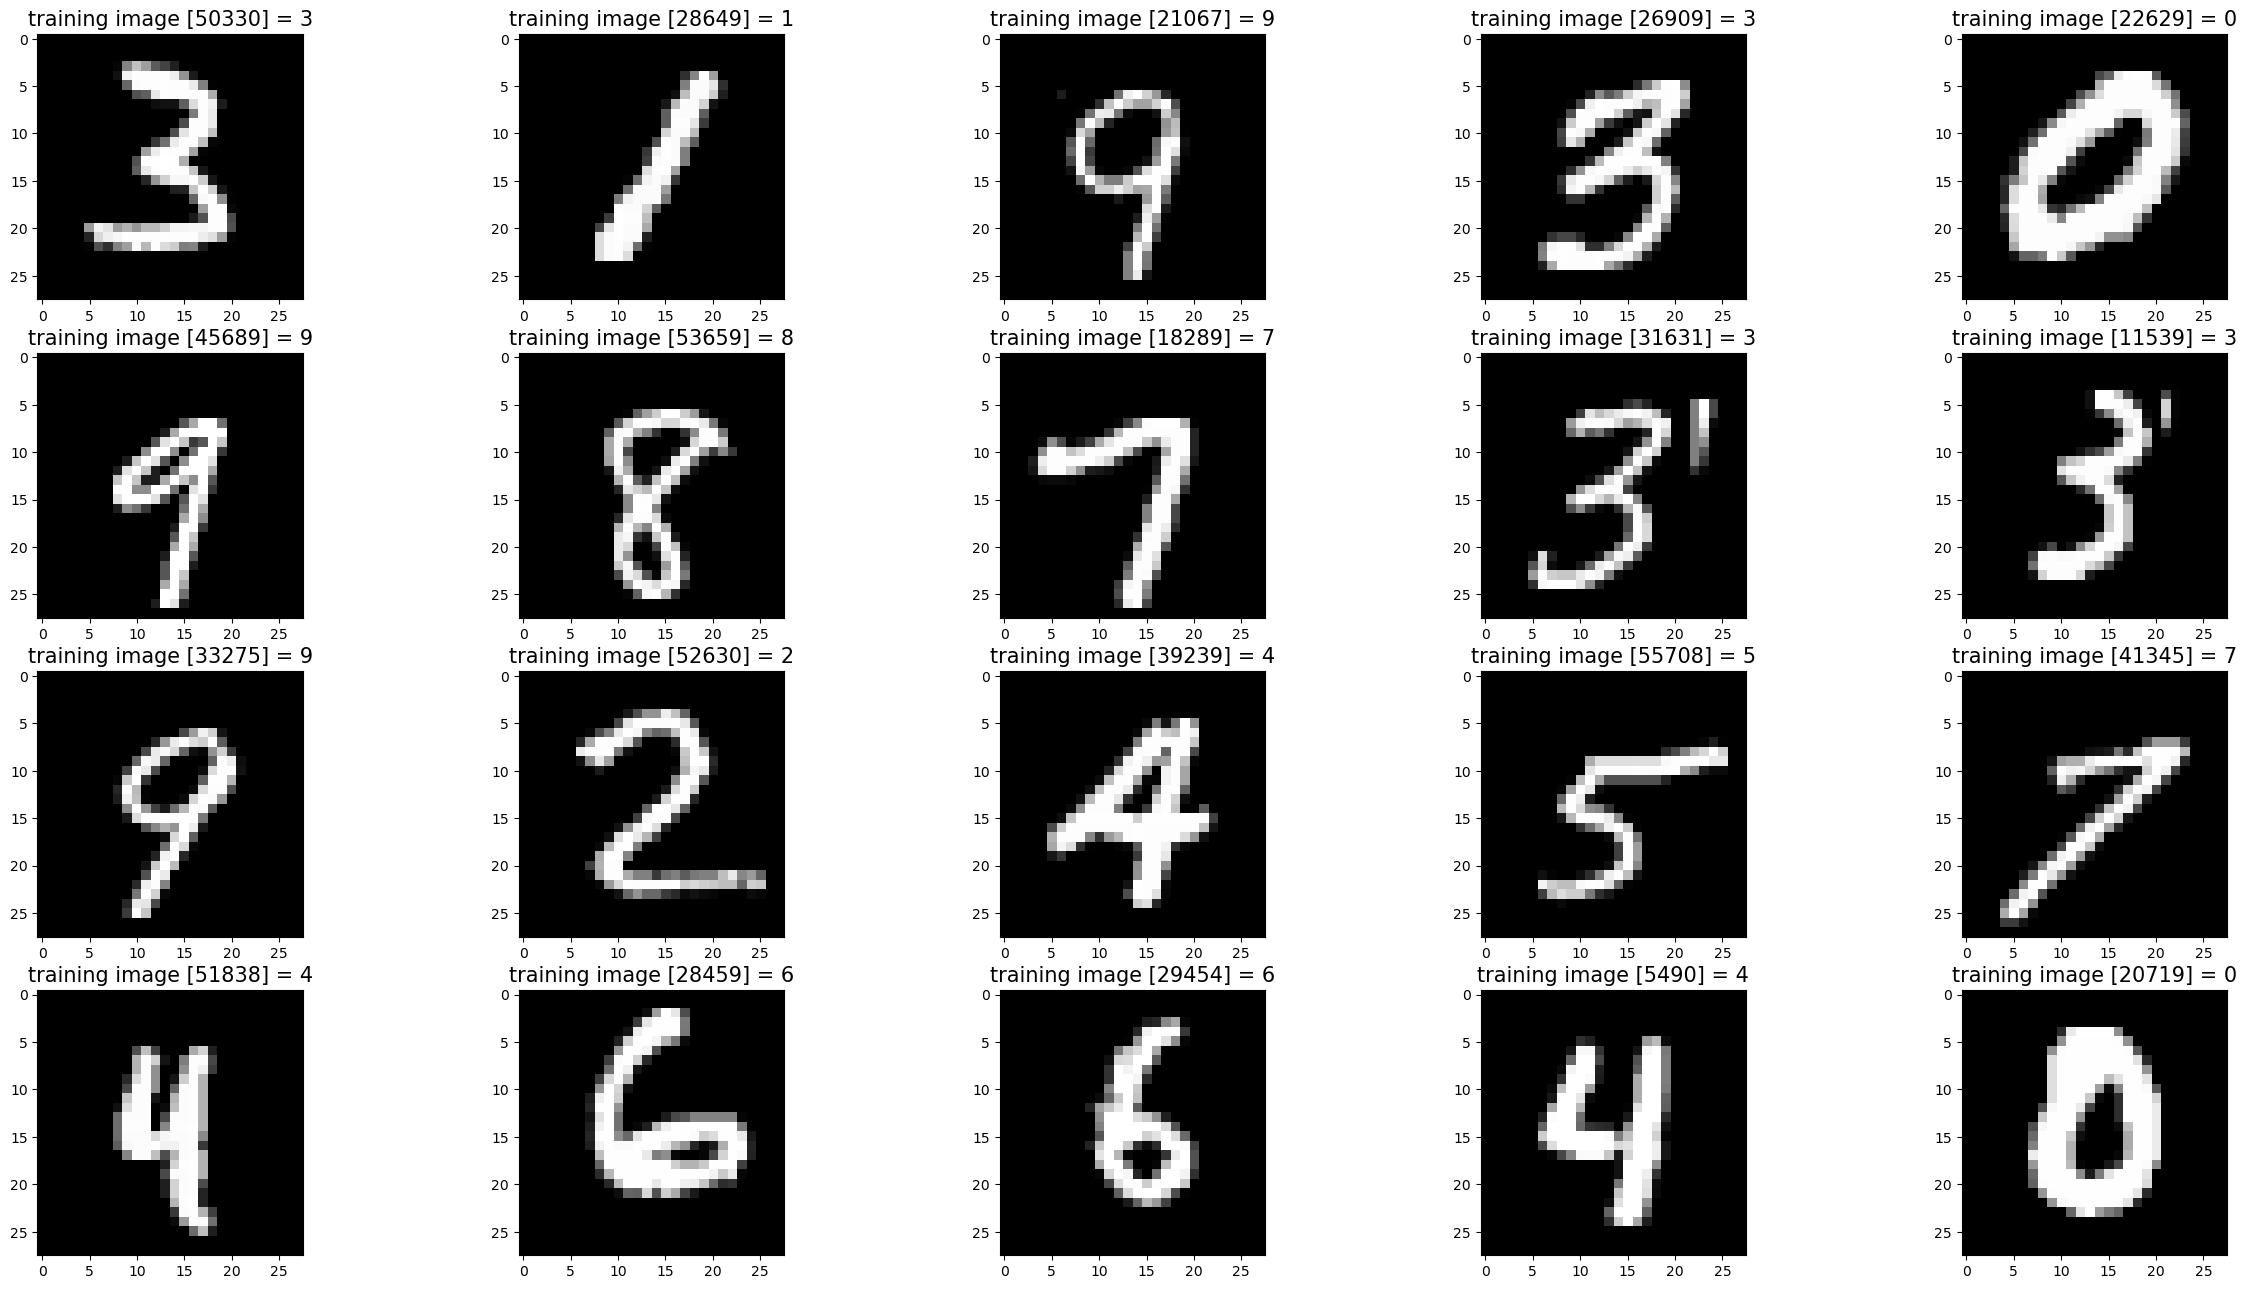

In [11]:
images_2_show = []
titles_2_show = []

for i in range(0, 20):
    r = np.random.randint(1, 60000)
    images_2_show.append(X_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

show_images(images_2_show, titles_2_show)

# Building the Model

In [13]:
class Model:
    def __init__(self):
        self.dense1 = Dense(784, 128, weight_regularizer_l2=1e-4, bias_regularizer_l2=1e-4)
        self.activation1 = ReLU()
        self.dropout1 = Dropout(0.2)
        self.dense2 = Dense(128, 64, weight_regularizer_l2=1e-4, bias_regularizer_l2=1e-4)
        self.activation2 = ReLU()
        self.dropout2 = Dropout(0.2)
        self.dense3 = Dense(64, 10, weight_regularizer_l2=1e-4, bias_regularizer_l2=1e-4)
        self.loss_activation = CategoricalCrossEntropy()

    def forward(self, X, y, type='train'):
        if type == 'train':
            self.dropout1.train()
            self.dropout2.train()
        else:
            self.dropout1.eval()
            self.dropout2.eval()
        
        self.dense1.forward(X)
        self.activation1.forward(self.dense1.output)
        self.dropout1.forward(self.activation1.output)
        self.dense2.forward(self.dropout1.output)
        self.activation2.forward(self.dense2.output)
        self.dropout2.forward(self.activation2.output)
        self.dense3.forward(self.dropout2.output)
        self.loss_activation.forward(self.dense3.output, y, type)

        return self.loss_activation.output

    def backward(self, y_pred, y_true):
        self.loss_activation.backward(y_pred, y_true)
        self.dense3.backward(self.loss_activation.dinputs)
        self.dropout2.backward(self.dense3.dinputs)
        self.activation2.backward(self.dropout2.dinputs)
        self.dense2.backward(self.activation2.dinputs)
        self.dropout1.backward(self.dense2.dinputs)
        self.activation1.backward(self.dropout1.dinputs)
        self.dense1.backward(self.activation1.dinputs)

# Helper Functions

In [15]:
def reshape_data(X, n_samples):
    return X.reshape(n_samples, 28*28)

In [16]:
def calculate_accuracy(y_pred, y_true):
    if len(y_pred.shape) == 2:
        y_pred = np.argmax(y_pred, axis=1)
    accuracy = np.mean(y_pred == y_true)
    return accuracy

# Training Pipeline

In [18]:
X_train, y_train = load_mnist('../mnist-data/', kind='train')
X_train = reshape_data(X_train, n_samples=60000)

model = Model()
optimizer = Adam()

learning_rate = 0.001
epochs = 20

batch_size = 64

loss_per_epoch = []
accuracy_per_epoch = []

start_time = time.time()

for epoch in trange(epochs, desc="Training Epochs"):
    epoch_loss = []
    epoch_accuracy = []
    
    for starting_idx in range(0, len(y_train), batch_size):
        # define batch
        ending_idx = min(len(y_train), starting_idx + batch_size)
        X_batch = X_train[starting_idx : ending_idx]
        y_batch = y_train[starting_idx : ending_idx]
        # forward pass
        predictions = model.forward(X_batch, y_batch)
        # calculate loss and accuracy
        epoch_loss.append(model.loss_activation.loss_value)
        epoch_accuracy.append(calculate_accuracy(predictions, y_batch))
        # backward pass
        model.backward(predictions, y_batch)
        # update params
        optimizer.pre_update_params()
        optimizer.update_params(model.dense1)
        optimizer.update_params(model.dense2)
        optimizer.update_params(model.dense3)
        optimizer.post_update_params()

    print(f"epoch {epoch+1}: loss = {np.mean(epoch_loss):.4f}, acc = {np.mean(epoch_accuracy):.4f}")

    loss_per_epoch.append(np.mean(epoch_loss))
    accuracy_per_epoch.append(np.mean(epoch_accuracy))

end_time = time.time()

Training Epochs:   5%|██▎                                          | 1/20 [00:02<00:47,  2.50s/it]

epoch 1: loss = 0.6531, acc = 0.8112


Training Epochs:  10%|████▌                                        | 2/20 [00:04<00:42,  2.34s/it]

epoch 2: loss = 0.2635, acc = 0.9218


Training Epochs:  15%|██████▊                                      | 3/20 [00:07<00:39,  2.35s/it]

epoch 3: loss = 0.1957, acc = 0.9426


Training Epochs:  20%|█████████                                    | 4/20 [00:10<00:42,  2.65s/it]

epoch 4: loss = 0.1577, acc = 0.9543


Training Epochs:  25%|███████████▎                                 | 5/20 [00:12<00:40,  2.70s/it]

epoch 5: loss = 0.1320, acc = 0.9601


Training Epochs:  30%|█████████████▌                               | 6/20 [00:15<00:36,  2.64s/it]

epoch 6: loss = 0.1192, acc = 0.9631


Training Epochs:  35%|███████████████▋                             | 7/20 [00:17<00:32,  2.47s/it]

epoch 7: loss = 0.1062, acc = 0.9681


Training Epochs:  40%|██████████████████                           | 8/20 [00:19<00:28,  2.38s/it]

epoch 8: loss = 0.0982, acc = 0.9696


Training Epochs:  45%|████████████████████▎                        | 9/20 [00:21<00:25,  2.31s/it]

epoch 9: loss = 0.0891, acc = 0.9731


Training Epochs:  50%|██████████████████████                      | 10/20 [00:24<00:22,  2.26s/it]

epoch 10: loss = 0.0870, acc = 0.9722


Training Epochs:  55%|████████████████████████▏                   | 11/20 [00:26<00:20,  2.27s/it]

epoch 11: loss = 0.0816, acc = 0.9748


Training Epochs:  60%|██████████████████████████▍                 | 12/20 [00:28<00:17,  2.23s/it]

epoch 12: loss = 0.0773, acc = 0.9754


Training Epochs:  65%|████████████████████████████▌               | 13/20 [00:30<00:15,  2.25s/it]

epoch 13: loss = 0.0738, acc = 0.9773


Training Epochs:  70%|██████████████████████████████▊             | 14/20 [00:33<00:13,  2.28s/it]

epoch 14: loss = 0.0715, acc = 0.9773


Training Epochs:  75%|█████████████████████████████████           | 15/20 [00:35<00:11,  2.28s/it]

epoch 15: loss = 0.0718, acc = 0.9774


Training Epochs:  80%|███████████████████████████████████▏        | 16/20 [00:37<00:09,  2.27s/it]

epoch 16: loss = 0.0667, acc = 0.9793


Training Epochs:  85%|█████████████████████████████████████▍      | 17/20 [00:40<00:06,  2.29s/it]

epoch 17: loss = 0.0672, acc = 0.9788


Training Epochs:  90%|███████████████████████████████████████▌    | 18/20 [00:42<00:04,  2.30s/it]

epoch 18: loss = 0.0616, acc = 0.9806


Training Epochs:  95%|█████████████████████████████████████████▊  | 19/20 [00:44<00:02,  2.28s/it]

epoch 19: loss = 0.0651, acc = 0.9790


Training Epochs: 100%|████████████████████████████████████████████| 20/20 [00:46<00:00,  2.34s/it]

epoch 20: loss = 0.0630, acc = 0.9798


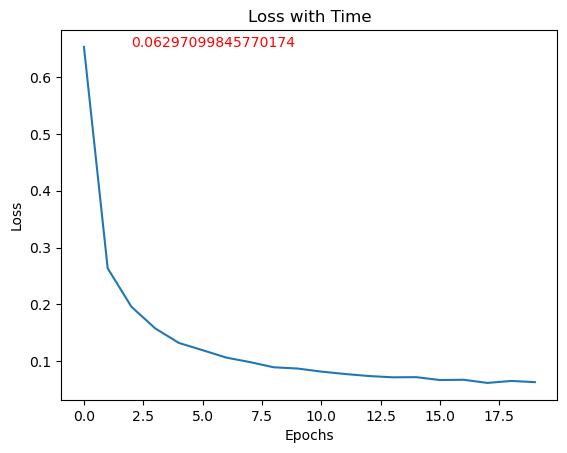

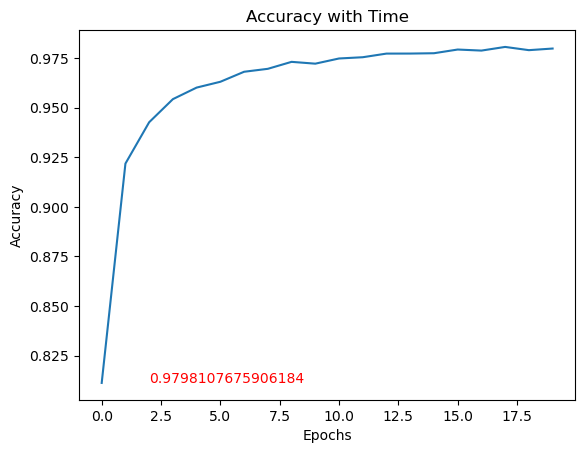

In [19]:
plt.annotate(loss_per_epoch[-1], xy=(2, max(loss_per_epoch)), color='red')
plt.plot(range(epochs), loss_per_epoch)
plt.title('Loss with Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.annotate(accuracy_per_epoch[-1], xy=(2, min(accuracy_per_epoch)), color='red')
plt.plot(range(epochs), accuracy_per_epoch)
plt.title('Accuracy with Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [20]:
training_time = end_time - start_time
mins, secs = divmod(training_time, 60)
print(f"Total Training Time = {int(mins)}m {int(secs)}s")

Total Training Time = 0m 46s


# Model Validation

In [22]:
X_test, y_test = load_mnist('../mnist-data/', kind='test')
X_test = reshape_data(X_test, 10000)

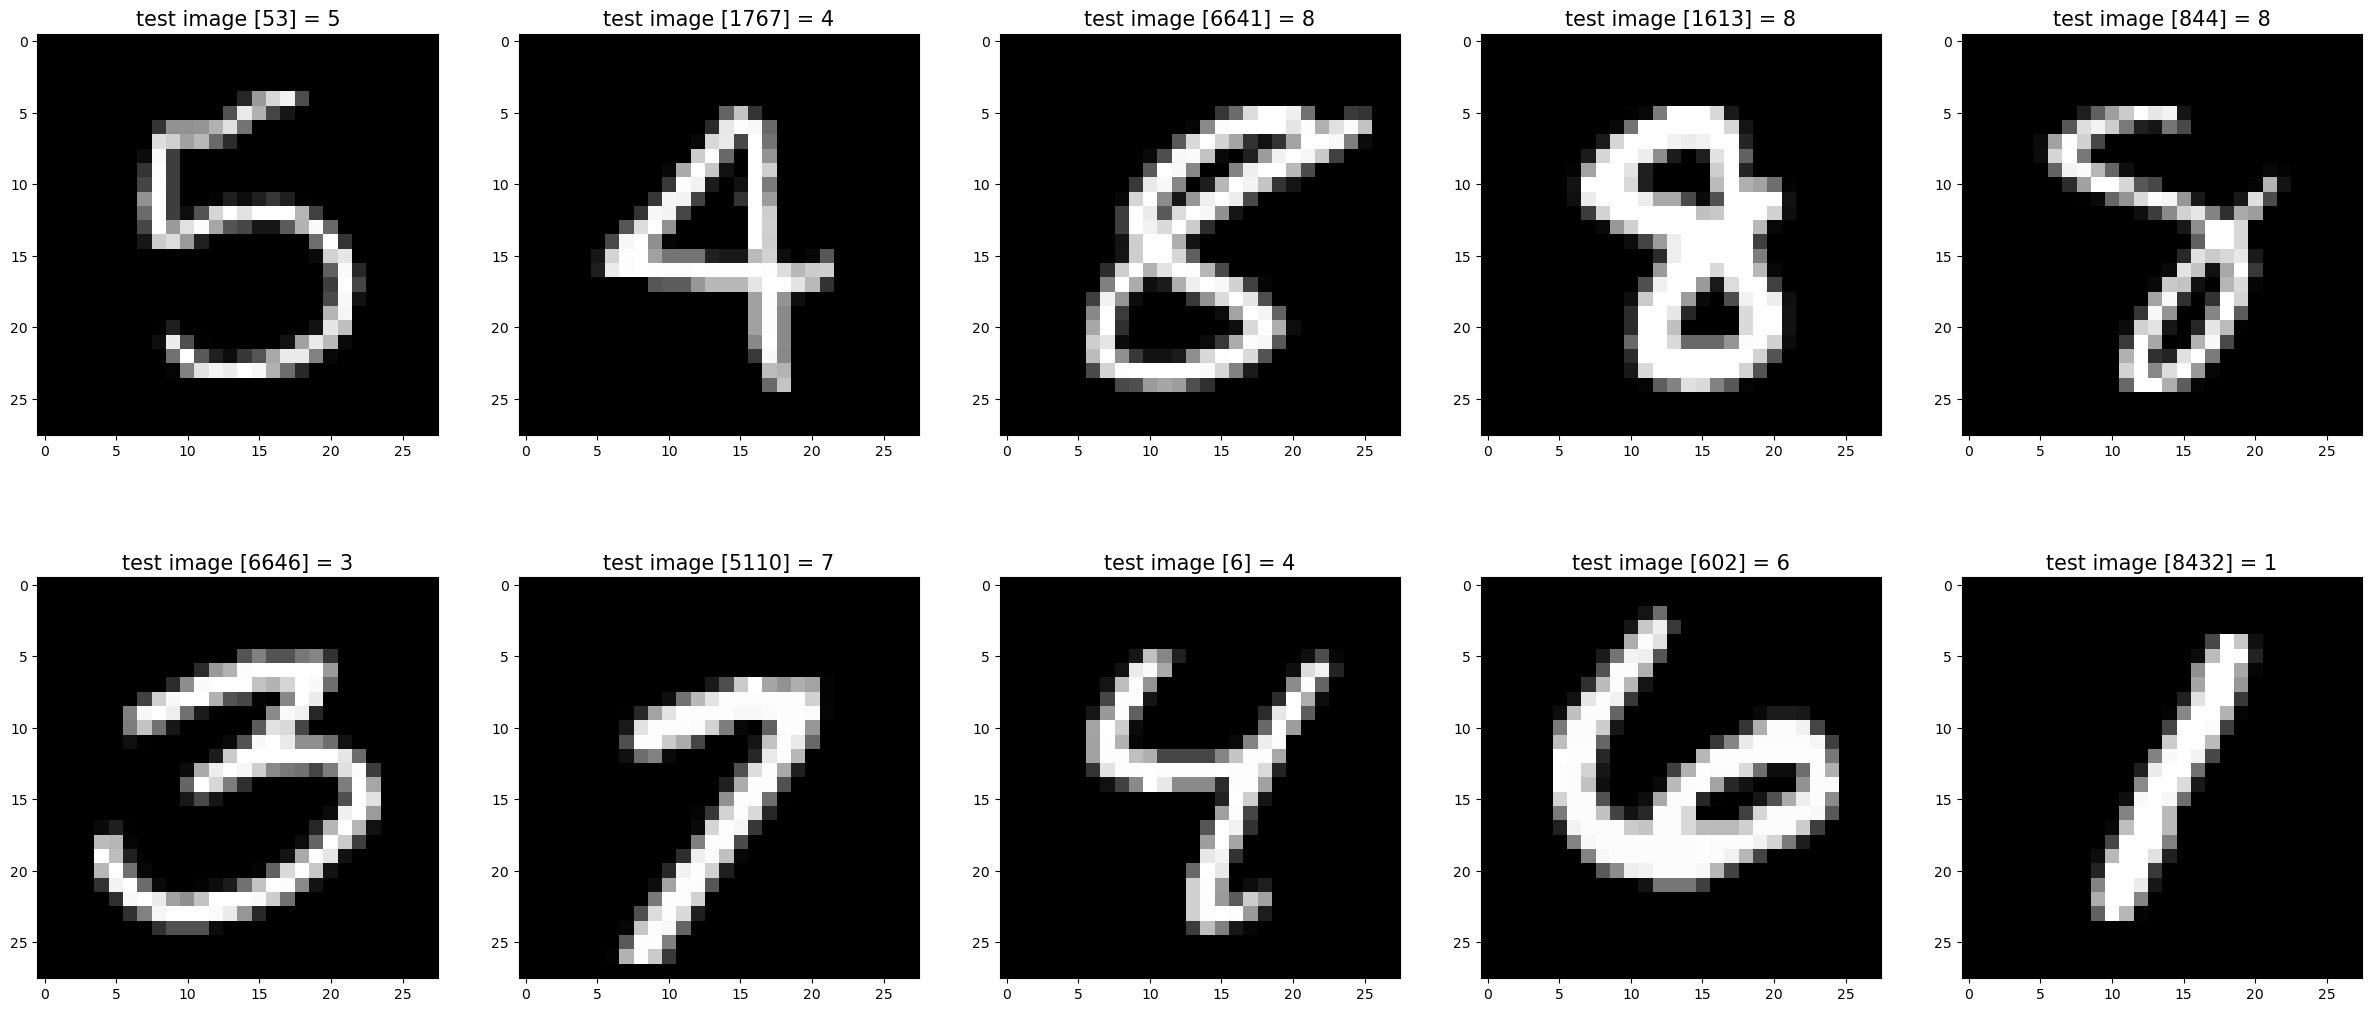

In [23]:
images_2_show = []
titles_2_show = []

for i in range(0, 10):
    r = np.random.randint(1, 10000)
    images_2_show.append(X_test.reshape(10000, 28, 28)[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [24]:
test_predictions = model.forward(X_test, y_test, type='test')
test_predictions = np.argmax(test_predictions, axis=1)
print(f"loss: {model.loss_activation.loss_value:.4f}")
print(f"accuracy: {calculate_accuracy(test_predictions, y_test)}")

loss: 0.0379
accuracy: 0.9764


In [25]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

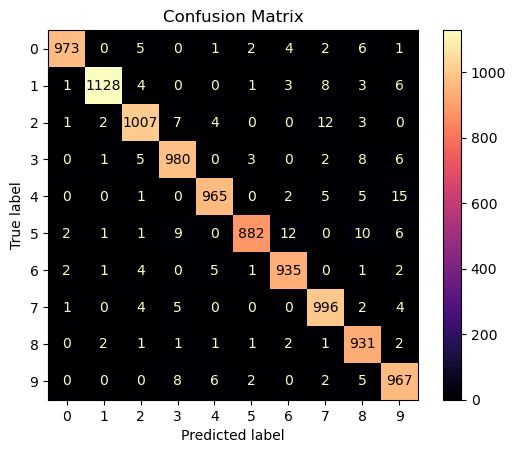

In [26]:
cm = confusion_matrix(test_predictions, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='magma')
plt.title("Confusion Matrix")
plt.show()

In [27]:
print(classification_report(test_predictions, y_test, digits=4))

              precision    recall  f1-score   support

           0     0.9929    0.9789    0.9858       994
           1     0.9938    0.9775    0.9856      1154
           2     0.9758    0.9720    0.9739      1036
           3     0.9703    0.9751    0.9727      1005
           4     0.9827    0.9718    0.9772       993
           5     0.9888    0.9556    0.9719       923
           6     0.9760    0.9832    0.9796       951
           7     0.9689    0.9842    0.9765      1012
           8     0.9559    0.9883    0.9718       942
           9     0.9584    0.9768    0.9675       990

    accuracy                         0.9764     10000
   macro avg     0.9763    0.9763    0.9762     10000
weighted avg     0.9766    0.9764    0.9764     10000



# Train the Model on Rest of the Data

In [29]:
epochs = 5

for epoch in range(epochs):
    epoch_loss = []
    epoch_accuracy = []
    
    for starting_idx in range(0, len(y_test), batch_size):
        # define batch
        ending_idx = min(len(y_test), starting_idx + batch_size)
        X_batch = X_test[starting_idx : ending_idx]
        y_batch = y_test[starting_idx : ending_idx]
        # forward pass
        predictions = model.forward(X_batch, y_batch)
        # calculate loss and accuracy
        epoch_loss.append(model.loss_activation.loss_value)
        epoch_accuracy.append(calculate_accuracy(predictions, y_batch))
        # backward pass
        model.backward(predictions, y_batch)
        # update params
        optimizer.pre_update_params()
        optimizer.update_params(model.dense1)
        optimizer.update_params(model.dense2)
        optimizer.update_params(model.dense3)
        optimizer.post_update_params()

    print(f"epoch {epoch+1}: loss = {np.mean(epoch_loss):.4f}, acc = {np.mean(epoch_accuracy):.4f}")

epoch 1: loss = 0.1087, acc = 0.9668
epoch 2: loss = 0.0756, acc = 0.9780
epoch 3: loss = 0.0563, acc = 0.9830
epoch 4: loss = 0.0484, acc = 0.9848
epoch 5: loss = 0.0442, acc = 0.9867


# Saving the Model

In [31]:
# import joblib
# joblib.dump(model, 'model.joblib')

In [32]:
# save the model parameters
np.savez('parameters.npz',
         w1=model.dense1.weights, b1=model.dense1.biases,
         w2=model.dense2.weights, b2=model.dense2.biases,
         w3=model.dense3.weights, b3=model.dense3.biases)